In [1]:
import os

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("PIL version : ", PIL.__version__)

!python --version

torch version :  2.7.1+cpu
torchvision version :  0.22.1+cpu
torchinfo version :  1.8.0
numpy version :  2.3.1
matplotlib version :  3.10.3
PIL version :  11.3.0
Python 3.11.4


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [4]:
data_dir = os.path.join("dataset", "data_undersampled")
train_dir = os.path.join(data_dir, "train")

print("Data Directory:", data_dir)
print("Training Data Directory:", train_dir)

Data Directory: dataset\data_undersampled
Training Data Directory: dataset\data_undersampled\train


In [5]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease']


In [6]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [7]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4259, 0.4885, 0.3073],
            std=[0.2213, 0.2226, 0.2090]
        )
    ]
)

print(type(transform_normalized))
print("-----------------")
print(transform_normalized)


<class 'torchvision.transforms.transforms.Compose'>
-----------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4259, 0.4885, 0.3073], std=[0.2213, 0.2226, 0.209])
)


In [8]:
dataset = datasets.ImageFolder(root = train_dir, transform = transform_normalized)

print('Length of dataset:', len(dataset))

Length of dataset: 5435


In [9]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset,[0.8,0.2], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 4348
Length of validation dataset: 1087


In [10]:
length_dataset = len(dataset)
length_train = len(train_dataset)
length_val = len(val_dataset)

percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


  0%|          | 0/5435 [00:00<?, ?it/s]

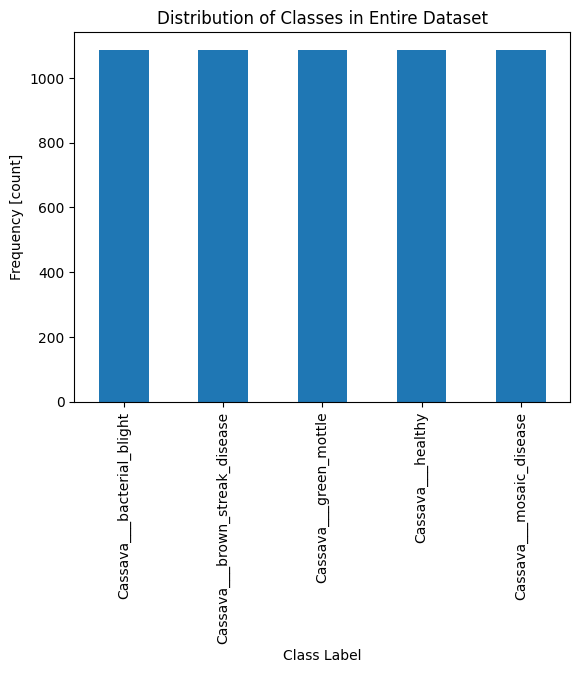

In [11]:
from training import class_counts

dataset_counts = class_counts(dataset)

# Make a bar chart from the function output
dataset_counts.sort_values().plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Entire Dataset");

  0%|          | 0/4348 [00:00<?, ?it/s]

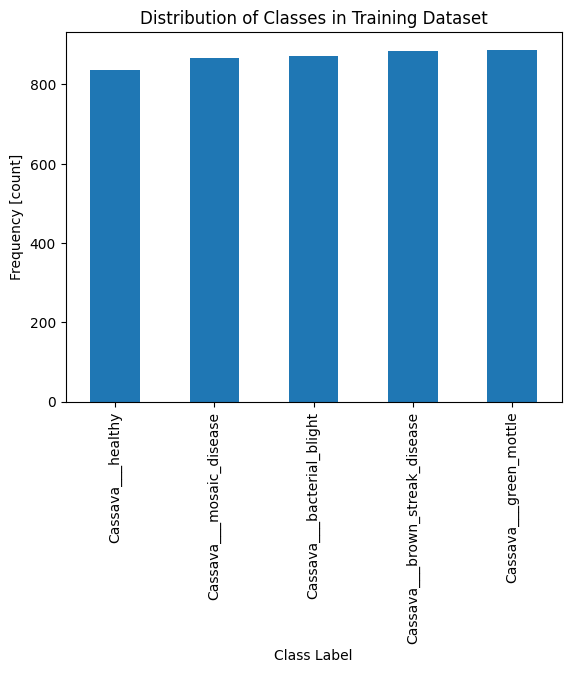

In [12]:
train_counts = class_counts(train_dataset)

# Make a bar chart from the function output
train_counts.sort_values().plot(kind='bar')

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

  0%|          | 0/1087 [00:00<?, ?it/s]

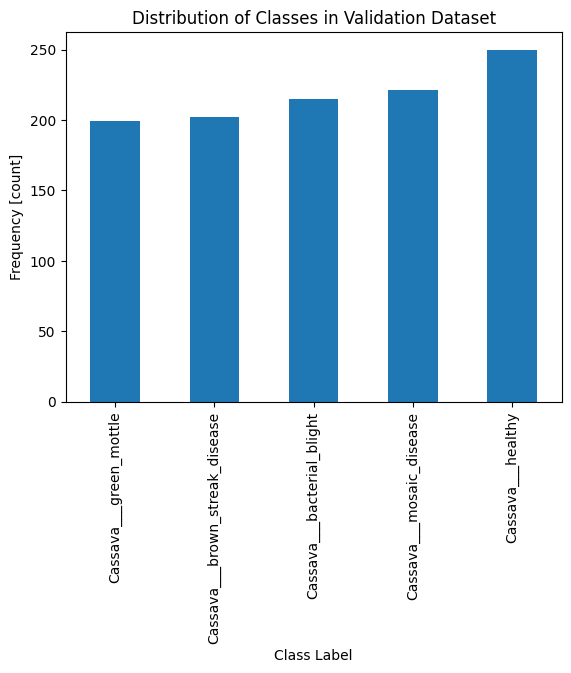

In [13]:
from training import class_counts
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.sort_values().plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");


In [14]:
# DataLoader?

In [15]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [16]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [17]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

image_shape = images.shape
print("Shape of batch of images", image_shape)

label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


In [18]:
labels

tensor([0, 4, 1, 0, 4, 0, 4, 0, 1, 1, 1, 1, 3, 3, 3, 0, 3, 1, 3, 4, 0, 0, 3, 4,
        4, 1, 3, 2, 3, 4, 1, 0])

In [19]:
model = torch.nn.Sequential()

In [20]:
# Convolutional layer 1 (sees 3x224x224 image tensor)
conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
model.append(conv1)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [21]:
max_pool1 = nn.MaxPool2d(2, 2)
model.append(torch.nn.ReLU())
model.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [22]:
# Convolutional layer 2 (sees 16x112x112 tensor)
conv2 = nn.Conv2d(16, 32, 3, padding = 1)
max_pool2 = nn.MaxPool2d(2, 2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [23]:
# Convolutional layer 3 (sees 32x56x56 tensor)
conv3 = nn.Conv2d(32, 64, 3, padding = 1)
max_pool3 = nn.MaxPool2d(2, 2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [24]:
model.append(torch.nn.Flatten())
model.append(nn.Dropout(0.5))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
)

In [25]:
# Linear layer (64 * 28 * 28 -> 500)
linear1 = torch.nn.Linear(64 *28 * 28, 500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
)


In [26]:
# Linear layer (500 -> 5)
output_layer = nn.Linear(500, 5)
model.append(output_layer)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)


In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [28]:
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

In [29]:

height = 224
width = 224
summary(model, input_size=(batch_size, 3, height, width))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [30]:
from training import train

In [31]:
train?

Signature:
train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device='cpu',
    use_train_accuracy=True,
)
Docstring: <no docstring>
File:      d:\projects\crop disease detections\training.py
Type:      function

In [32]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=5,
    device=device
)

Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.50
    Training accuracy: 0.33
    Validation loss: 1.51
    Validation accuracy: 0.29


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.43
    Training accuracy: 0.38
    Validation loss: 1.48
    Validation accuracy: 0.32


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.39
    Training accuracy: 0.41
    Validation loss: 1.44
    Validation accuracy: 0.34


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.29
    Training accuracy: 0.46
    Validation loss: 1.42
    Validation accuracy: 0.36


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 1.19
    Training accuracy: 0.53
    Validation loss: 1.45
    Validation accuracy: 0.36


In [35]:
model = torch.load("model_trained.pth", weights_only=False)
model.to("cpu")

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

In [41]:
df = pd.read_csv('post_train_evaluation_metrics.csv')

In [42]:
train_losses = df['Train Loss']
valid_losses = df['Validation Loss']

train_accuracies = df['Train Accuracy']
valid_accuracies = df['Validation Accuracy']

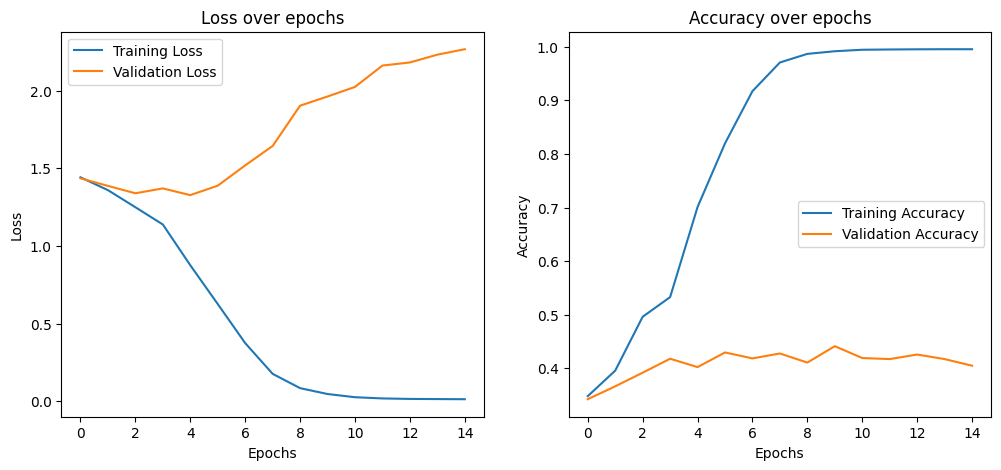

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [44]:
from training import predict

probabilities_val =  predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

Predicting:   0%|          | 0/34 [00:00<?, ?it/s]

tensor([4, 1, 1,  ..., 1, 2, 3])
